# Image Matching

## Template matching


* The template matching method uses a distance metric (e.g *normalized cross-correlation*) to match a template to multi-channel image. 
* The output of the method is an intensity image, where each pixel value computed by the distance metric.
* In practice, you can crop a single object of interest (e.g a cell) and predict where other such similar objects are in the image.
* Not rotation invariant, so it performs better four approximately rounded objects in a relatively consistent direction.

In [1]:
import numpy as np
from scipy.signal import correlate2d

### Method 0: Direct 2D correlation of the image with the template

$$y[m,n] = \sum_{k,l} h[k,l]x[m+k,n+l]$$

In [2]:
def match_template_corr( x , temp ):
    y = np.empty(x.shape)
    y = correlate2d(x,temp,'same')
    return y

### Method 1: Direct 2D correlation of the image with the *zero-mean* template

$$y[m,n] = \sum_{k,l} (h[k,l]-\bar{h}) x[m+k,n+l]$$

In [3]:
def match_template_corr_zmean( x , temp ):
    return match_template_corr(x , temp - temp.mean())

### Method 2: SSD

$$y[m,n] = \sum_{k,l} (h[k,l]- x[m+k,n+l])^2 $$
$$= \sum_{k,l}h[k,l]^2 - 2\sum_{k,l}h[k,l]x[m+k,n+l] + \sum_{k,l}x[m+k,n+l]^2 $$

In [4]:
def match_template_ssd( x , temp ):
    term1 = np.sum(temp*temp)
    term2 = -2*correlate2d(x, temp,'same')
    term3 = correlate2d( x*x , np.ones(temp.shape),'same' )
    return 1 - np.sqrt(term1 + term2 + term3)

### Method 3: Normalized cross-correlation


$$\gamma[\color{BlueViolet}{u,v}] = \frac{\sum_{x,y} (f[x,y]-\bar{f_{u,v}}) (t[\color{Red}{x-u,y-v}] - \bar{t})}{ \sqrt{\sum_{x,y}(f[x,y]-\bar{f_{u,v}})^2 \sum_{x,y}(t[\color{Red}{x-u,y-v}] - \bar{t})^2 }}$$

![](media/xcorr.png)

In the above image $u=2$, $v=4$, $x \in \{1,2,3\}$, and $y \in \{3,4,5\}$

In [5]:
def match_template_xcorr( f , t ):
    f_c = f - correlate2d( f , np.ones(t.shape)/np.prod(t.shape), 'same') 
    t_c = t - t.mean()
    numerator = correlate2d( f_c , t_c , 'same' )
    d1 = correlate2d( np.square(f_c) , np.ones(t.shape), 'same')
    d2 = np.sum( np.square( t_c ))
    denumerator = np.sqrt( np.maximum( d1 * d2 , 0 )) # to avoid sqrt of negative
    response = np.zeros( f.shape )
    valid = denumerator > np.finfo(np.float32).eps # mask to avoid division by zero
    response[valid] = numerator[valid]/denumerator[valid]
    return response

### Example on a practical application of template matching

In [6]:
# !pip install interactivecrop --user
# !pip install tabulate --user
# !pip install  opencv-python --user
#! pip install itk --user
# !pip install itkwidgets --user
# !pip install itk-io
import itk

from itkwidgets import view
import itkwidgets
from IPython.display import display

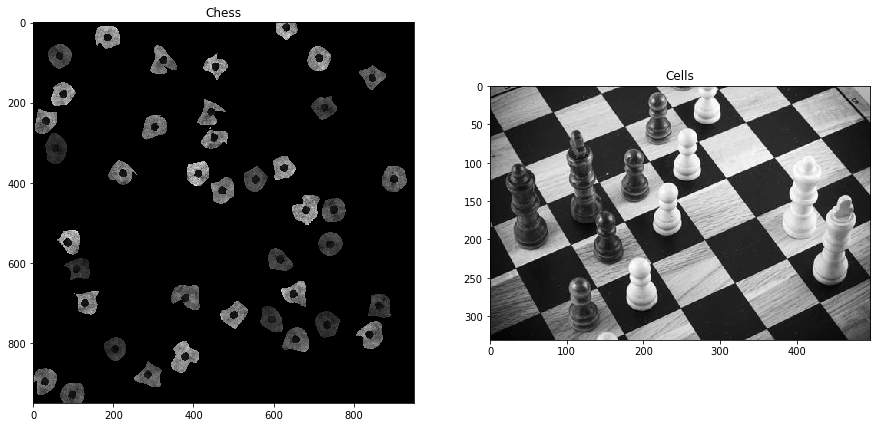

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os.path import isfile , join
from PIL import Image
from cvutils import rgb2gray
import cv2
%matplotlib inline

imgs_dir = 'images'
imgs_names = ['ProcessPlateSparse_wA03_s08_z1_t1_CELLMASK.png','chess.jpg']
imgs_fnames = [ join( imgs_dir, img_name) for img_name in imgs_names ]
imgs_rgb = [ np.array(Image.open(img)) for img in imgs_fnames ]
imgs_gray = [ rgb2gray( img ) for img in imgs_rgb ]

fig, ax = plt.subplots(1,2,figsize = (15, 10))
ax[1].set_title('Cells')
ax[0].imshow(imgs_gray[0], cmap = 'gray')
ax[0].set_title('Chess')
ax[1].imshow(imgs_gray[1], cmap = 'gray')

In [8]:
viewers = [ view(img,annotations=False, ui_collapsed=True) for img in imgs_gray]
for viewer in viewers:
    display( viewer )


Viewer(annotations=False, geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.…

Viewer(annotations=False, geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.…

In [ ]:
templates = [ img[viewer.roi_slice()] for img,viewer in zip(imgs_gray,viewers)]

fig, ax = plt.subplots(len(imgs_gray),2,figsize = (15, 10))
plt.autoscale(True)
for i,(im,temp) in enumerate(zip(imgs_gray,templates)):
    ax[i,0].imshow(im, cmap = 'gray')
    ax[i,1].imshow(temp, cmap = 'gray')
plt.show()

In [ ]:
matches_corr = [ match_template_corr(x,h) for (x,h) in zip(imgs_gray,templates)]

In [ ]:
matches_corr_zmean = [ match_template_corr_zmean(x,h) for (x,h) in zip(imgs_gray,templates)]

In [ ]:
matches_ssd = [ match_template_ssd(x,h) for (x,h) in zip(imgs_gray,templates)]

In [ ]:
matches_xcorr = [ match_template_xcorr(x,h) for (x,h) in zip(imgs_gray,templates)]

In [ ]:
methods_n = 4
patches = zip(imgs_gray,templates,matches_corr,matches_corr_zmean,matches_ssd,matches_xcorr)

In [ ]:
fig, ax = plt.subplots(len(imgs_gray)*(methods_n+1),2,figsize = (20, 40))
plt.autoscale(True)
for i,(im,temp,mcorr,mcorrz,mssd,mxcorr) in enumerate(patches):
    def get_rect_on_maximum(y,template):
        ij = np.unravel_index(np.argmax(y), y.shape)
        x, y = ij[::-1]
        # highlight matched region
        htemp, wtemp = template.shape
        rect = plt.Rectangle((x-wtemp//2, y-htemp//2), wtemp, htemp, edgecolor='r', facecolor='none')
        return rect,x,y
    row = (methods_n+1)*i 
    ax[row,0].imshow(im, cmap = 'gray')
    ax[row,1].imshow(temp, cmap = 'gray')
    
    ax[row+ 1,0].imshow(im, cmap = 'gray')
    r,x,y = get_rect_on_maximum(mcorr,temp)
    ax[row + 1,0].add_patch(r)
    ax[row + 1,1].imshow(mcorr, cmap = 'gray')
    ax[row + 1,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    
    r,x,y = get_rect_on_maximum(mcorrz,temp)
    ax[row + 2,0].imshow(im, cmap = 'gray')
    ax[row + 2,0].add_patch(r)
    ax[row + 2,1].imshow(mcorrz, cmap = 'gray')
    ax[row + 2,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

    r,x,y = get_rect_on_maximum(mssd,temp)
    ax[row + 3,0].imshow(im, cmap = 'gray')
    ax[row + 3,0].add_patch(r)
    ax[row + 3,1].imshow(mssd, cmap = 'gray')
    ax[row + 3,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    
    r,x,y = get_rect_on_maximum(mxcorr,temp)
    ax[row + 4,0].imshow(im, cmap = 'gray')
    ax[row + 4,0].add_patch(r)
    ax[row + 4,1].imshow(mxcorr, cmap = 'gray')
    ax[row + 4,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

## Scale invariant feature descriptor (SIFT) 


* Features or **key-points** of an image are corners which are unique in the image.
* Harris is a corner detector, we have discussed Previously. 
* Corner detectors are invariant for translation, illumination and rotation. **But it is variant for scaling**. 

**Lets see an example**

Next figure shows two different scales of same image. 

<span style="display:block;text-align:center"><img style="width:75%"  src="../images/sift_scale_invariant.jpg"></span>

* In smaller image,  it's easy to detect that there is a corner, but what about same image in the large scale. It will be difficult to detect that corner so this feature point will not be recognized for all scales. 
* So size of the window will effect the detection of corners. Large corners needs large windows and smaller corners needs smaller windows. 

Scale invariant feature descriptor (SIFT) is not a new way to find key-points or corners that is invariant to scale. But it is a descriptor of detected corners of different image scales or image pyramids. 

### Image pyramids and scale-spaces

Image pyramids or image scale space is the proposed method to handle images in different scales. We have different scale-spaces 

* Gaussian scale space (Gaussian pyramid)

* Laplacian of gaussian (LOG) scale space 

* Difference of gaussian (DOG) scale space 

The basic idea to build scale space is shown in the following figure 

**Gaussian Pyramid**

<span style="display:block;text-align:center"><img style="width:55%"  src="../images/Image_pyramid.png"></span>


[source](https://en.wikipedia.org/wiki/Pyramid_(image_processing))

**LOG Pyramid**

<span style="display:block;text-align:center"><img style="width:85%"  src="../images/LOG.png"></span>


In SIFT we usually prefer DOG scale space which is an approximate of LOG and simpler in calculation. 

### SIFT scale space 

In SIFT Pyramid we have 
* Octaves 

  different levels of image resolutions (pyramids levels)

* Scales 
  
  different scales of window in each octave level (different $$\sigma$$ of gaussian window)

  ![](../images/sift_dog.jpg)

### Key-point (corner) scale localization

For each key-point (corner) we need to find its best scale which have maximum value (cornerness measure). It is achieved by comparing same corner with its neighbors of above and lower scales and select scale with maximum value. For same iamge, it is not necessary for its corners to be localized at same scale.

![](../images/sift_local_extrema.jpg)

### Extract SIFT feature descriptor

![](../images/sift-fingerprint.jpg)

[source](http://aishack.in/tutorials/sift-scale-invariant-feature-transform-features/)

After localization of a key-point in our scale space. We can get its SIFT descriptor as follow

* Extract a $$16 \times 16$$ window centered by this point.
* Get gradient magnitude and multiply it by a $$16 \times 16$$ gaussian window of $$\sigma =1.5$$
* Get gradient angle direction. 
* Adjusting orientation (To be rotation invariant):
    * Get the gradient angle of the window and Quantize them to 36 values (0, 10, 20, ..., 360)
    * Locate dominant corner direction which is most probable angle (angle with max value in 36 bit angle histogram)
    * subtract dominant direction from gradient angle.

![](../images/siftOriented.png)

* Divide this $$16 \times 16$$ patch to sixteen $$4 \times 4$$ blocks
* For each block get magnitude weighted angle histogram and normalize it (divide by total gradient magnitudes). 
 
 angles (quantized to 8 angles [0, 45, 90, ... , 360]) based on its relevant gradient magnitude i.e (histogram of angle 0 = sum(all magnitudes with angle 0))

 ![](../images/histangles.png)



* SIFT feature descriptor will be a vector of 128 element (16 blocks $$\times$$ 8 values from each block)


## Feature matching
The basic idea of feature matching is to calculate the sum square difference between two different feature descriptors (SSD). So feature will be matched with another with minimum SSD value. 

$$
SSD = \sum (v_1 - v_2)^2
$$

where $$v_1$$ and $$v_2$$ are two feature descriptors.

![](../images/matcher_result1.jpg)


### Brute-Force matcher
In brute-force matcher we have to match descriptor of all features in an image to descriptors of all features in another image. It is extremely expensive as we know any brute-force algorithm will guarantee getting a solution, but doesn't guarantee getting optimal solution.

### RANSAC 
Random sample consensus is an iterative method for estimation of parameters of a mathematical model. We will model the transformation of points in source image to destination one, and try to find an estimate of model parameters. The basic idea of RANSAC algorithm is shown in the following flow chart. 

![](../images/ransac.png)

RANSAC is a robust feature matcher. For example we can model the difference between two images to a set of transformations and run RANSAC to find best model that maximize correct matching.